In [1]:
using DrWatson
@quickactivate "projectdir()"

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase

In [3]:
function scale_embeddings(X)
    return (X .- mean(eachrow(X))') * (X'X)^(-0.5)
end

function diagram(X, dim_max; alpha=true)
    points = tuple.(eachcol(X)...)
    dgm = ripserer(Alpha(points), dim_max=dim_max)
    return dgm
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X, dim_max)
    DY = diagram(Y, dim_max)
    return [Bottleneck()(DX[d], DY[d]) for d in 1:dim_max+1]
end

bottleneck_distances (generic function with 1 method)

In [21]:
function generate_sbm(n, k, p, r)
    f = (x, y) -> (r + p * (x == y)) * log(n) / n^0.9
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function simulate_one(A, d, epsilon, method)
    X, _, _ = rdpg.spectralEmbed(A, d=d + 1, scale=false)
    A_private = rdpg.edgeFlip(A, ϵ=epsilon)

    if method == :eps
        A_private = A_private .- rdpg.privacy(ϵ=epsilon)
    end

    X_private, _, _ = rdpg.spectralEmbed(A_private, d=d + 1, scale=false)

    if method == :eps
        X_private = X_private ./ (1 - 2 * rdpg.privacy(ϵ=epsilon))
    elseif method == :noeps
        X = rdpg.scale_embeddings(X)
        X_private = rdpg.scale_embeddings(X_private)
    end
    return bottleneck_distances(X, X_private, d)
end

simulate_one (generic function with 1 method)

## Illustration of differentially-private community detection using *persistent homology*

In [5]:
# p, r = 0.8, 0.2
p, r = 20, 1
clust = 3
n = 900
ϵ = 2
theme(:dao)

In [6]:
f = (x, y) -> ((r + p * (x == y))) * log(n) / n
Z = rand(1:clust, 900)
A = rdpg.Adjacency(f, Z)

900×900 SparseArrays.SparseMatrixCSC{Int64, Int64} with 47496 stored entries:
⣾⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣾⣿⣿⣾⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⢿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣿⣷
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣻⣿⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣾⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

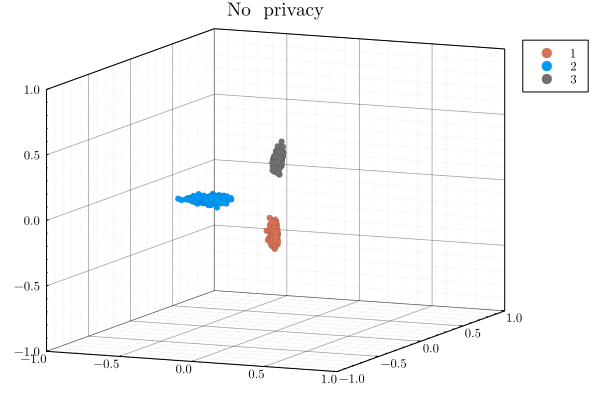

In [7]:
X, _, _ = rdpg.spectralEmbed(A, d=3, scale=false)
plt = @pipe [tuple(x...) for x in eachrow(X)]  |> scatter(_, groups=Z, lim = (-1,1), title="No  privacy")

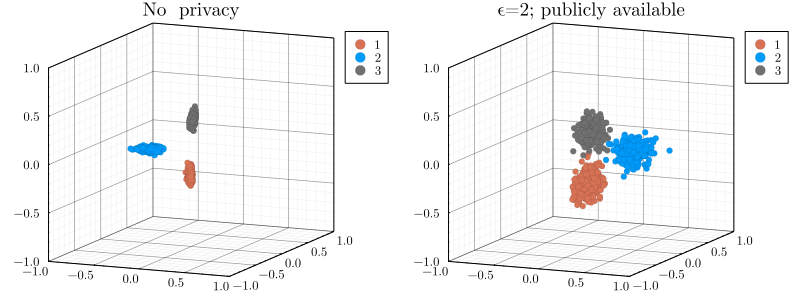

In [8]:
A_private = rdpg.edgeFlip(A, ϵ=ϵ)

A_with_eps = (A_private .- rdpg.privacy(ϵ=ϵ)) ./ (1 - 2 * rdpg.privacy(ϵ=ϵ))
X_with_eps, _ = rdpg.spectralEmbed(A_with_eps, d=3, scale=false)
plt_with_eps = @pipe [tuple(x...) for x in eachrow(X_with_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly available", lim=(-1, 1))

plot(plt, plt_with_eps, layout=(1, 2), size=(800,300))

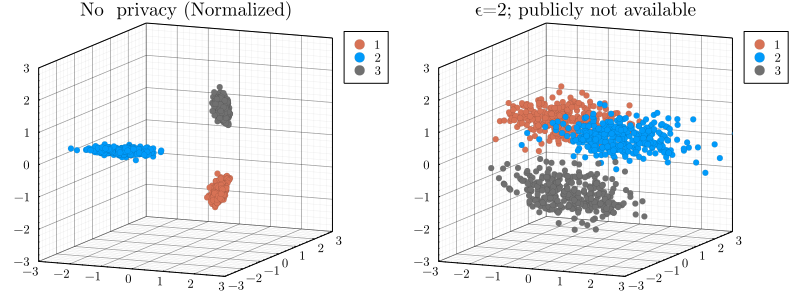

In [9]:
plt_standardized = @pipe [tuple(x...) for x in eachrow(StatsBase.standardize(ZScoreTransform, X, dims=1))] |> scatter(_, groups=Z, lim=(-3, 3), title="No  privacy (Normalized)")

X_without_eps, _ = rdpg.spectralEmbed(A_private, d=3, scale=false)
X_without_eps = StatsBase.standardize(ZScoreTransform, X_without_eps, dims=1)
plt_without_eps = @pipe [tuple(x...) for x in eachrow(X_without_eps)] |> scatter(_, groups=Z, title="ϵ=2; publicly not available", lim=(-3, 3))

plot(plt_standardized, plt_without_eps, layout=(1, 2), size=(800, 300))

## Comparison with ![Seif at al. (2022)](https://arxiv.org/abs/2202.00636)

In the following, for a stochastic blockmodel with $C=3$ clusters, we examine the bottleneck distance as a function of the number of vertices $n$ when $\epsilon_n \asymp \log^k(n)$ for $k \in \{\frac 23, \frac 34, 1\}$. The result in ![Seif at al. (2022)](https://arxiv.org/abs/2202.00636) requires that $\epsilon_n \asymp (\log(n)))$. 

For more information on differentially-private community detection using persistence diagrams, please see ![the clustering Jupyter notebook](./clustering.ipynb).

In [22]:
repeats = 10
Ks = [2 / 3, 3 / 4, 1]
# Ks_legend = ["1/2", "2/3", "1"]
# Ks_legend = ["0.33", "0.66", "0.90"]
Ks_legend = ["0.66", "0.75", "1.00"]
N = [100, 200, 400, 600, 800];

In [23]:
p, r = 9, 1
clust = 3
n = length(N);

In [24]:
results_3 = [zeros(repeats, n) for _ in 1:length(Ks)];

prog = Progress(convert(Int, n * repeats * length(Ks)))
for i in 1:n
    A = generate_sbm(N[i], clust, p, r)
    for j in 1:repeats
        for k in 1:length(Ks)
        
            ϵn = 10 * log(N[i])^(Ks[k])
            error = simulate_one(A, 0, ϵn, :eps)
            results_3[k][j, i] = error[1]
            next!(prog)

        end
    end
end

Progress:   1%|▌                                        |  ETA: 0:00:19

Progress:   8%|███▎                                     |  ETA: 0:00:04

Progress:  15%|██████▎                                  |  ETA: 0:00:03

Progress:  23%|█████████▎                               |  ETA: 0:00:02

Progress:  26%|██████████▋                              |  ETA: 0:00:02

Progress:  28%|███████████▌                             |  ETA: 0:00:02

Progress:  31%|████████████▋                            |  ETA: 0:00:02

Progress:  33%|█████████████▋                           |  ETA: 0:00:02

Progress:  35%|██████████████▌                          |  ETA: 0:00:02

Progress:  38%|███████████████▋                         |  ETA: 0:00:02

Progress:  40%|████████████████▍                        |  ETA: 0:00:02

Progress:  42%|█████████████████▎                       |  ETA: 0:00:03

Progress:  43%|█████████████████▌                       |  ETA: 0:00:03

Progress:  43%|█████████████████▊                       |  ETA: 0:00:03

Progress:  44%|██████████████████                       |  ETA: 0:00:03

Progress:  45%|██████████████████▍                      |  ETA: 0:00:03

Progress:  45%|██████████████████▋                      |  ETA: 0:00:03

Progress:  46%|██████████████████▉                      |  ETA: 0:00:03

Progress:  47%|███████████████████▏                     |  ETA: 0:00:03

Progress:  47%|███████████████████▍                     |  ETA: 0:00:03

Progress:  48%|███████████████████▋                     |  ETA: 0:00:03

Progress:  49%|████████████████████                     |  ETA: 0:00:03

Progress:  49%|████████████████████▎                    |  ETA: 0:00:04

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

Progress:  51%|████████████████████▊                    |  ETA: 0:00:04

Progress:  51%|█████████████████████                    |  ETA: 0:00:04

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:04

Progress:  53%|█████████████████████▋                   |  ETA: 0:00:04

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:04

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:04

Progress:  55%|██████████████████████▍                  |  ETA: 0:00:04

Progress:  55%|██████████████████████▋                  |  ETA: 0:00:04

Progress:  56%|███████████████████████                  |  ETA: 0:00:04

Progress:  57%|███████████████████████▎                 |  ETA: 0:00:04

Progress:  57%|███████████████████████▌                 |  ETA: 0:00:04

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:04

Progress:  59%|████████████████████████                 |  ETA: 0:00:04

Progress:  59%|████████████████████████▍                |  ETA: 0:00:04

Progress:  60%|████████████████████████▋                |  ETA: 0:00:04

Progress:  61%|████████████████████████▉                |  ETA: 0:00:04

Progress:  61%|█████████████████████████▏               |  ETA: 0:00:04

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:04

Progress:  63%|█████████████████████████▊               |  ETA: 0:00:04

Progress:  63%|██████████████████████████               |  ETA: 0:00:04

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:04

Progress:  65%|██████████████████████████▌              |  ETA: 0:00:04

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:04

Progress:  66%|███████████████████████████              |  ETA: 0:00:04

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:04

Progress:  67%|███████████████████████████▋             |  ETA: 0:00:04

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:04

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:04

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:04

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:04

Progress:  71%|█████████████████████████████            |  ETA: 0:00:04

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:04

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:04

Progress:  73%|█████████████████████████████▊           |  ETA: 0:00:04

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:04

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:04

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:04

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:04

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:04

Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:04

Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:04

Progress:  78%|████████████████████████████████         |  ETA: 0:00:04

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:04

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:04

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:04

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:04

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:04

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:04

Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:04

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:04

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:04

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:03

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:03

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:03

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:03

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:03

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:03

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:03

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:03

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:03

Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:00:03

Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:02

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:02

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:02

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:02

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:02

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:02

Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:01

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:00

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


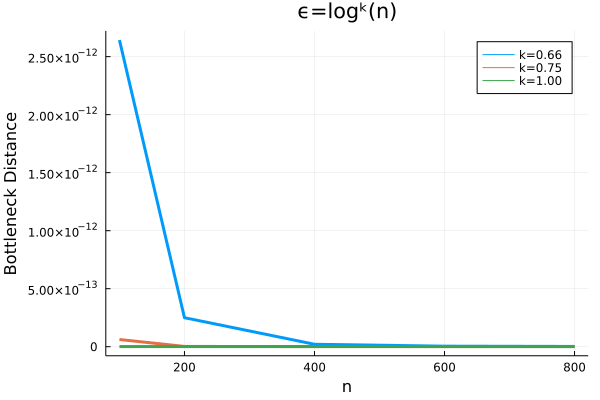

In [25]:
theme(:default)
plt = plot(title="ϵ=logᵏ(n)", xlabel="n", ylabel="Bottleneck Distance")
for k in 1:length(Ks)
    plot!(plt, N,
        mean(results_3[k], dims=1)',
        # ribbon=std(results[k], dims=1),
        ms=:o,
        label = "k=$(Ks_legend[k])",
        lw=3, fillapha=0.01,
    )
end
plt